In [83]:
import numpy as np
import MITgcmutils
import matplotlib.pyplot as plt
from utils.resample_to_latlon import resample_to_latlon

path_grid = "ECCO2/LLC270/ECCO-Darwin_extension/grid"
path_3d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_DIC_3d"
path_2d = "ECCO2/LLC270/ECCO-Darwin_extension/budget/average_2d"

#### Variable list

In [3]:
fldList_3d = ['TRAC01  ','ADVxTr01','ADVyTr01','ADVrTr01','DFxETr01','DFyETr01','DFrETr01',
              'DFrITr01','gDAR01  ','cDIC    ','cDIC_PIC','respDIC ','rDIC_DOC','rDIC_POC','dDIC_PIC']
fldList_2d = ['ETAN    ','oceFWflx','SFLUX   ','TFLUX   ','oceSPflx','oceQsw  ','fluxCO2 ','gDICsurf',
           'gDICEpr ','gALKEpr ','gNO3Epr ','gNO2Epr ','gNH4Epr ','gO2Epr  ','gPO4Epr ','gFeTEpr ','gSiO2Epr']

mapping_3d = list(zip(range(len(fldList_3d)),fldList_3d))
mapping_2d = list(zip(range(len(fldList_2d)),fldList_2d))

variable_selection_2d = [6,8]
variable_selection_3d = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14]


# display(mapping_3d)
# print()
# display(mapping_2d)

variable_names = [mapping_3d[idx][1] for idx in variable_selection_3d] + [mapping_2d[idx][1] for idx in variable_selection_2d]

#### importing data

In [74]:
d_2 = MITgcmutils.mds.rdmds(f"{path_2d}/average_2d.0000002232",rec=variable_selection_2d)
d_3 = MITgcmutils.mds.rdmds(f"{path_3d}/average_DIC_3d.0000002232",rec=variable_selection_3d)

# getting the grid details
depth_c = MITgcmutils.mds.rdmds(f"{path_grid}/RC")
depth_f = MITgcmutils.mds.rdmds(f"{path_grid}/RF")
lat = MITgcmutils.mds.rdmds(f"{path_grid}/XC")
lon = MITgcmutils.mds.rdmds(f"{path_grid}/YC")

lat_g = MITgcmutils.mds.rdmds(f"{path_grid}/XG")
lon_g = MITgcmutils.mds.rdmds(f"{path_grid}/YG")

#### Flatten 3d data

In [5]:
# Calculating delta depth
delta_depth_c = np.diff(depth_c, axis=0) * -1
delta_depth_c = delta_depth_c[:,0,0]

delta_depth_f = np.diff(depth_f, axis=0) * -1
delta_depth_f = delta_depth_f[:,0,0]

# getting index of top 100m depth
idx_top_100m = np.where(depth_c>=-100)[0]

In [6]:
# Using numpy
delta_depth_f_vec = delta_depth_f[idx_top_100m, np.newaxis, np.newaxis]
flattened_d3 = np.sum(delta_depth_f_vec * d_3[:,idx_top_100m,:,:], axis=1)/100 # Compressing the depth into 2D for top 100m

#### Combine and process variables

In [75]:
# combine data
combined_data = np.concatenate((flattened_d3, d_2), axis=0)

# create a mask for land mass to subtract from everything. using combined_data[0] (TRAC01) for mask
mask = combined_data[0]==0
combined_data[:,mask] = np.nan

# Interpolating the curvilinear line to the cartesian plane
new_grid_delta_lat, new_grid_delta_lon = 0.5, 0.5
new_grid_min_lat, new_grid_max_lat = -90, 90
new_grid_min_lon, new_grid_max_lon = -180, 180
new_shape = (combined_data.shape[0],
             int((new_grid_max_lat - new_grid_min_lat)/new_grid_delta_lat),
             int(((new_grid_max_lon - new_grid_min_lon)/new_grid_delta_lon)))

variables_cart = np.empty(new_shape)

for variable in range(combined_data.shape[0]):  
    lon_cart,lat_cart,_,_,variables_cart[variable] = \
                                resample_to_latlon(lat,lon,combined_data[variable],
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                fill_value = np.NaN,
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
                                                                         
variables_cart.shape

(15, 360, 720)

#### plotting

In [8]:
x,y = 561,174
print(lon[x,y],lat[x,y],d_3[0][0][x][y])

20.043834686279297 20.16666603088379 0.0


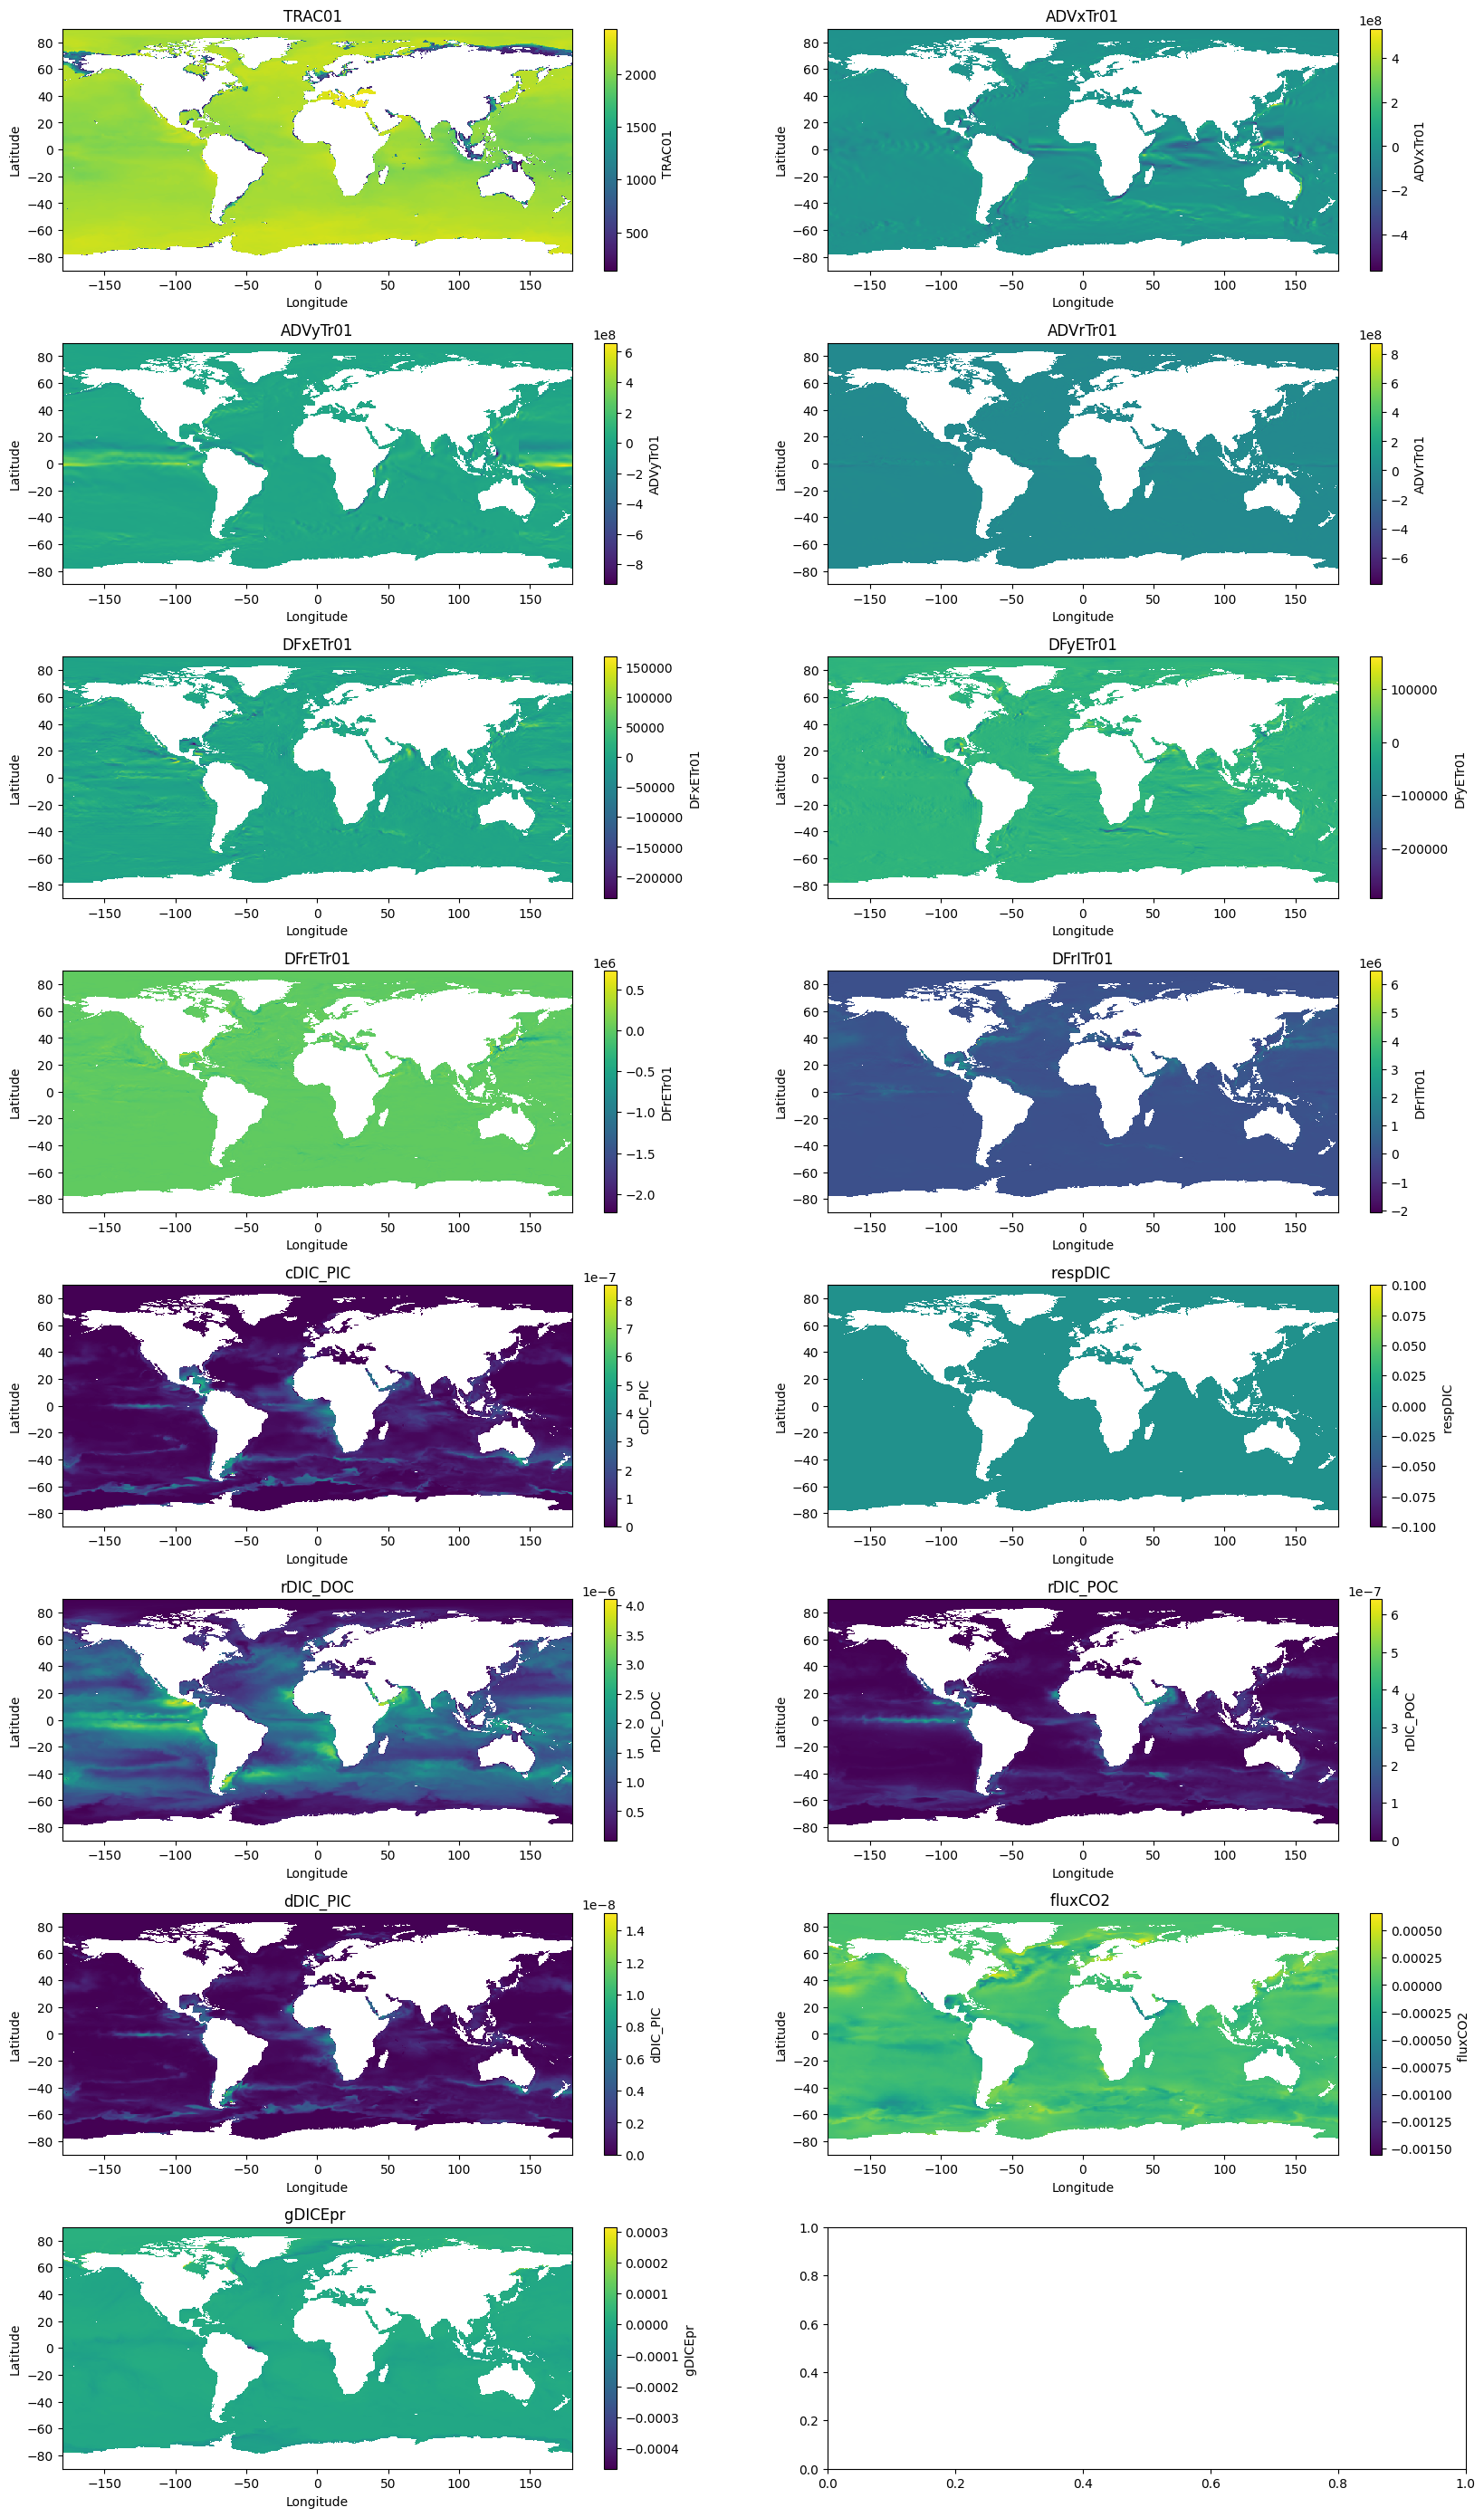

In [85]:
# pcolormesh
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = variables_cart[var_idx]  # Color values for the current variable

    # Scatter plot for the current variable
    pcolor = ax.pcolormesh(lon_cart,lat_cart, values, cmap='viridis', shading='auto')
    cbar = plt.colorbar(pcolor, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)

In [ ]:
# Scatter plot for surface level data
lat_flattened = lat.flatten()
lon_flattened = lon.flatten()

# Create a single figure with 7 rows and 2 columns
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names[0:-2]):
    ax = axes[var_idx]
    values = d_3[var_idx][0].flatten()  # Color values for the current variable

    # Scatter plot for the current variable
    scatter = ax.scatter(lat_flattened, lon_flattened, c=values, cmap='Blues', s=5, alpha=0.8)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)
    
for var_idx, var_name in enumerate(variable_names[-2:]):
    ax = axes[var_idx+13]
    values = d_2[var_idx].flatten()  # Color values for the current variable

    # Scatter plot for the current variable
    scatter = ax.scatter(lat_flattened, lon_flattened, c=values, cmap='Blues', s=5, alpha=0.8)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)

plt.savefig("top layer 3d data.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Scatter plot for integrated data
lat_flattened = lat.flatten()
lon_flattened = lon.flatten()

# Create a single figure with 7 rows and 2 columns
fig, axes = plt.subplots(8, 2, figsize=(20, 35))  # Adjust figsize for clarity
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through all variables
for var_idx, var_name in enumerate(variable_names):
    ax = axes[var_idx]
    values = combined_data[var_idx].flatten()  # Color values for the current variable

    # Scatter plot for the current variable
    scatter = ax.scatter(lat_flattened, lon_flattened, c=values, cmap='Blues', s=5, alpha=0.8)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(var_name)

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name}')
    plt.subplots_adjust(hspace=0.3)
    
plt.savefig("compressed 3d data.png", dpi=300, bbox_inches="tight")
# plt.show()

0.46748545998707414


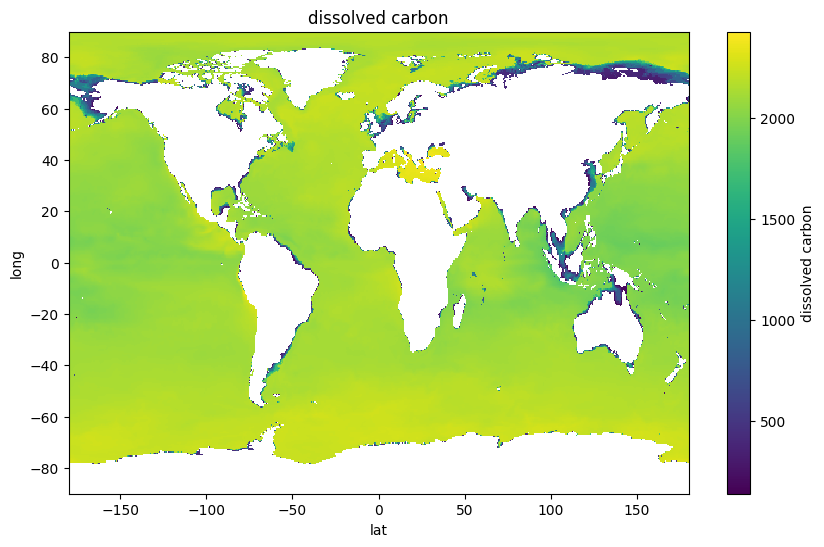

In [63]:
import time

start = time.perf_counter()
new_grid_delta_lat = 0.5
new_grid_delta_lon = 0.5

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180
field = combined_data[0]
field[field==0] = np.nan

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        resample_to_latlon(lat, \
                                lon, \
                                field,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
print(time.perf_counter()-start)



In [22]:
new_grid_lon_centers.shape

(180, 360)

In [24]:
field_nearest_1deg.shape

(180, 360)

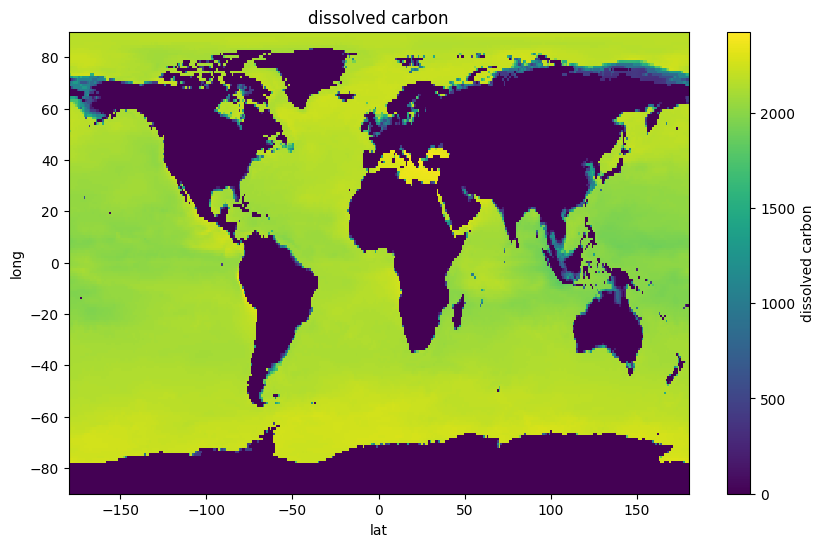

#### Excel Test

In [58]:
delta_depth_c = d_3[1]
variable_1_flattened = variable_1_data.reshape(variable_1_data.shape[0], -1)  # Shape: (50, 949770)

# Combine delta depth values with the flattened data
combined_data = np.column_stack((delta_depth_f, variable_1_flattened))

# Convert to DataFrame for better Excel formatting
column_names = ['Delta Depth'] + [f'Value_{i}' for i in range(variable_1_flattened.shape[1])]
df_excel = pd.DataFrame(combined_data, columns=column_names).T

# Save to Excel
excel_path = "variable_1_depth_comparison.xlsx"
df_excel.to_excel(excel_path, index=False)
